# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [8]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os 

# Set style for plots
sns.set_theme()
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [ ]:

def load_data(data_dir='/workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data', sessions=['Midterm 1', 'Midterm 2', 'Final']):
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    data_complete = []

    for student in sorted(os.listdir(data_dir)):
        student_path = os.path.join(data_dir, student)
        if not os.path.isdir(student_path):
            continue
        subject_id = student

        for session in sessions:
            session_path = os.path.join(student_path, session)
            if not os.path.exists(session_path):
                continue  

            try:
                # --- HR ---
                hr_raw = pd.read_csv(os.path.join(session_path, 'HR.csv'), header=None)
                hr_start = float(hr_raw.iloc[0, 0])
                hr_rate = float(hr_raw.iloc[1, 0])
                hr_data = hr_raw.iloc[2:, 0].astype(float).reset_index(drop=True)
                hr_times = pd.to_datetime(np.arange(len(hr_data)) / hr_rate + hr_start, unit='s', utc=True)
                hr_df = pd.DataFrame({'timestamp': hr_times, 'heart_rate': hr_data}).set_index('timestamp')
                hr_df = hr_df.resample('1s').mean()

                # --- EDA ---
                eda_raw = pd.read_csv(os.path.join(session_path, 'EDA.csv'), header=None)
                eda_start = float(eda_raw.iloc[0, 0])
                eda_rate = float(eda_raw.iloc[1, 0])
                eda_data = eda_raw.iloc[2:, 0].astype(float).reset_index(drop=True)
                eda_times = pd.to_datetime(np.arange(len(eda_data)) / eda_rate + eda_start, unit='s', utc=True)
                eda_df = pd.DataFrame({'timestamp': eda_times, 'eda': eda_data}).set_index('timestamp')
                eda_df = eda_df.resample('1s').mean()

                # --- TEMP ---
                temp_raw = pd.read_csv(os.path.join(session_path, 'TEMP.csv'), header=None)
                temp_start = float(temp_raw.iloc[0, 0])
                temp_rate = float(temp_raw.iloc[1, 0])
                temp_data = temp_raw.iloc[2:, 0].astype(float).reset_index(drop=True)
                temp_times = pd.to_datetime(np.arange(len(temp_data)) / temp_rate + temp_start, unit='s', utc=True)
                temp_df = pd.DataFrame({'timestamp': temp_times, 'temperature': temp_data}).set_index('timestamp')
                temp_df = temp_df.resample('1s').mean()

                # --- Merge signals ---
                df = pd.concat([hr_df, eda_df, temp_df], axis=1)
                df['subject_id'] = subject_id
                df['session'] = session
                df.reset_index(inplace=True)

                data_complete.append(df)

                print(f"Loaded {subject_id} - {session}")

            except Exception as e:
                print(f"Skipping {subject_id} - {session} due to error: {e}")
                continue

    return pd.concat(data_complete, ignore_index=True)


In [19]:
df = load_data()
print(df.shape)
print(df.head())

Loaded S1 - Midterm 1
Loaded S1 - Midterm 2
Loaded S1 - Final
Loaded S10 - Midterm 1
Loaded S10 - Midterm 2
Loaded S10 - Final
Loaded S2 - Midterm 1
Loaded S2 - Midterm 2
Loaded S2 - Final
Loaded S3 - Midterm 1
Loaded S3 - Midterm 2
Loaded S3 - Final
Loaded S4 - Midterm 1
Loaded S4 - Midterm 2
Loaded S4 - Final
Loaded S5 - Midterm 1
Loaded S5 - Midterm 2
Loaded S5 - Final
Loaded S6 - Midterm 1
Loaded S6 - Midterm 2
Loaded S6 - Final
Loaded S7 - Midterm 1
Loaded S7 - Midterm 2
Loaded S7 - Final
Loaded S8 - Midterm 1
Loaded S8 - Midterm 2
Loaded S8 - Final
Loaded S9 - Midterm 1
Loaded S9 - Midterm 2
Loaded S9 - Final
(443302, 6)
                  timestamp  heart_rate       eda  temperature subject_id  \
0 2018-10-13 12:56:06+00:00         NaN  0.010892        22.51         S1   
1 2018-10-13 12:56:07+00:00         NaN  0.023065        22.51         S1   
2 2018-10-13 12:56:08+00:00         NaN  0.023386        22.51         S1   
3 2018-10-13 12:56:09+00:00         NaN  0.022424        

## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [22]:
def preprocess_data(data, output_dir='/workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/Processed', file_format='csv'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Handle missing values
    # 2. Resample to regular intervals
    # 3. Remove outliers (z-score > 3)
    # 4. Save processed data to CSV files

    processed = []

    for subject_id in data['subject_id'].unique():
        subject_df = data[data['subject_id'] == subject_id].copy()
        subject_sessions = []

        for session in subject_df['session'].unique():
            session_df = subject_df[subject_df['session'] == session].copy()
            session_df = session_df.sort_values('timestamp').set_index('timestamp')

            # 1. Handle missing values
            missing_ratio = session_df.isna().mean()
            if (missing_ratio < 0.01).all():
                session_df = session_df.dropna()
            else:
                session_df = session_df.interpolate(method='time', limit_direction='both')

            # 2. Resample only numeric columns
            meta_cols = ['subject_id', 'session']
            numeric_df = session_df.drop(columns=meta_cols, errors='ignore')
            numeric_df = numeric_df.resample('1s').mean().interpolate()

            # Add metadata columns back
            numeric_df['subject_id'] = subject_id
            numeric_df['session'] = session

            session_df = numeric_df.reset_index().set_index('timestamp')
            subject_sessions.append(session_df)

        # Combine all sessions for subject
        subject_all = pd.concat(subject_sessions)

        # 3. Remove outliers using Z-score
        numeric_cols = ['heart_rate', 'eda', 'temperature']
        z_scores = np.abs(stats.zscore(subject_all[numeric_cols], nan_policy='omit'))
        subject_all = subject_all[(z_scores < 3.5).all(axis=1)]

        # 4. Save processed subject file
        outfile = os.path.join(output_dir, f"{subject_id}_processed.{file_format}")
        if file_format == 'csv':
            subject_all.reset_index().to_csv(outfile, index=False)
        elif file_format == 'parquet':
            subject_all.reset_index().to_parquet(outfile, index=False)
        elif file_format == 'feather':
            subject_all.reset_index().to_feather(outfile)
        else:
            raise ValueError("Unsupported file format. Choose from: 'csv', 'parquet', 'feather'.")

        processed.append(subject_all)
        print(f"Saved: {outfile}")

    return pd.concat(processed).reset_index(drop=True)
    
    
    

In [24]:
processed_df = preprocess_data(df, output_dir='/workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/Processed', file_format='csv')
print(processed_df.shape)

Saved: /workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/Processed/S1_processed.csv
Saved: /workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/Processed/S10_processed.csv
Saved: /workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/Processed/S2_processed.csv
Saved: /workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/Processed/S3_processed.csv
Saved: /workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/Processed/S4_processed.csv
Saved: /workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-r

## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [31]:
import os
import matplotlib.pyplot as plt
import pandas as pd

def plot_physiological_signals(data, subject_id, session, output_dir='/workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/plots'):
    """
    Create plots of physiological signals for a given subject and session.

    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files

    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Filter data for subject and session
    filtered = data[(data['subject_id'] == subject_id) & (data['session'] == session)].copy()

    # Use existing index for plotting (assumes it's already time-based or fine as-is)
    x = filtered.index

    # Create figure and subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex=True)

    # Plot heart rate
    axes[0].plot(x, filtered['heart_rate'], label='Heart Rate', color='red')
    axes[0].set_ylabel('Heart Rate (bpm)')
    axes[0].set_title(f'{subject_id} - {session} - Heart Rate')
    axes[0].grid(True)

    # Plot EDA
    axes[1].plot(x, filtered['eda'], label='EDA', color='blue')
    axes[1].set_ylabel('EDA (µS)')
    axes[1].set_title(f'{subject_id} - {session} - Electrodermal Activity')
    axes[1].grid(True)

    # Plot temperature
    axes[2].plot(x, filtered['temperature'], label='Temperature', color='green')
    axes[2].set_ylabel('Temperature (°C)')
    axes[2].set_xlabel('Index or Time')
    axes[2].set_title(f'{subject_id} - {session} - Skin Temperature')
    axes[2].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Save plot
    filename = f"{subject_id}_{session.replace(' ', '_')}_signals.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath)
    print(f"Plot saved to: {filepath}")

    return fig


Plot saved to: /workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/plots/S1_Midterm_1_signals.png


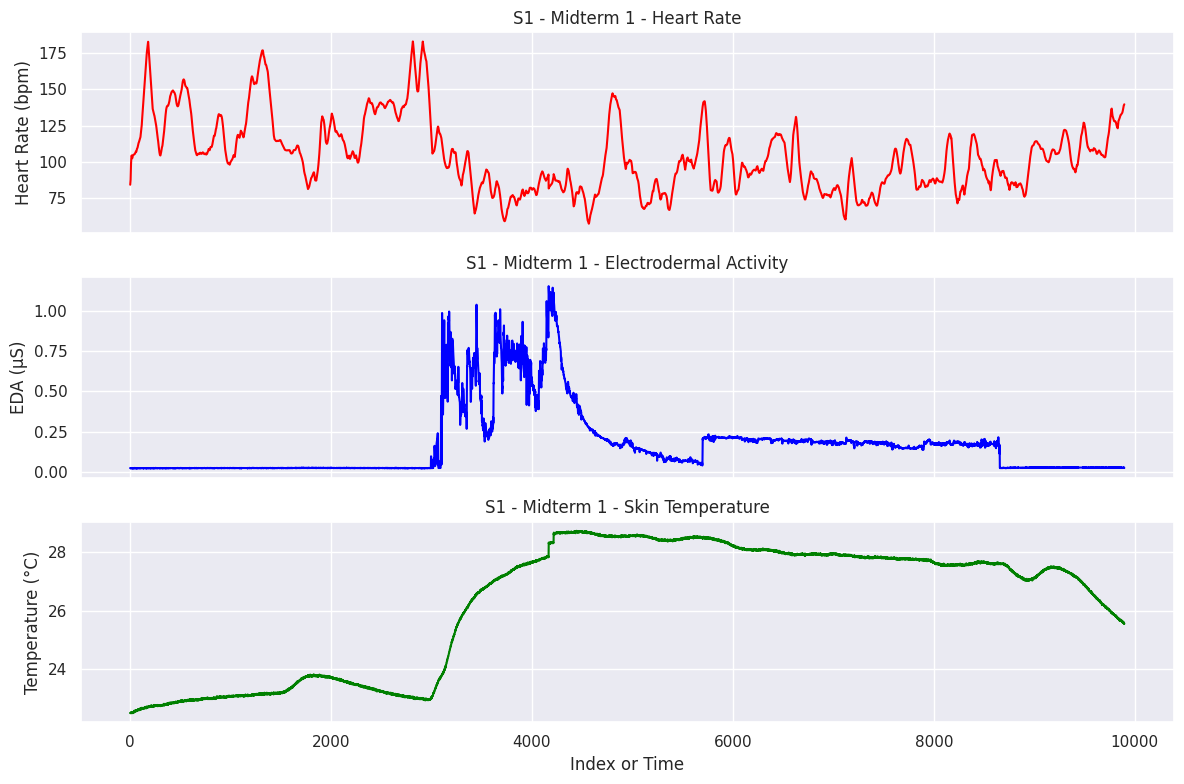

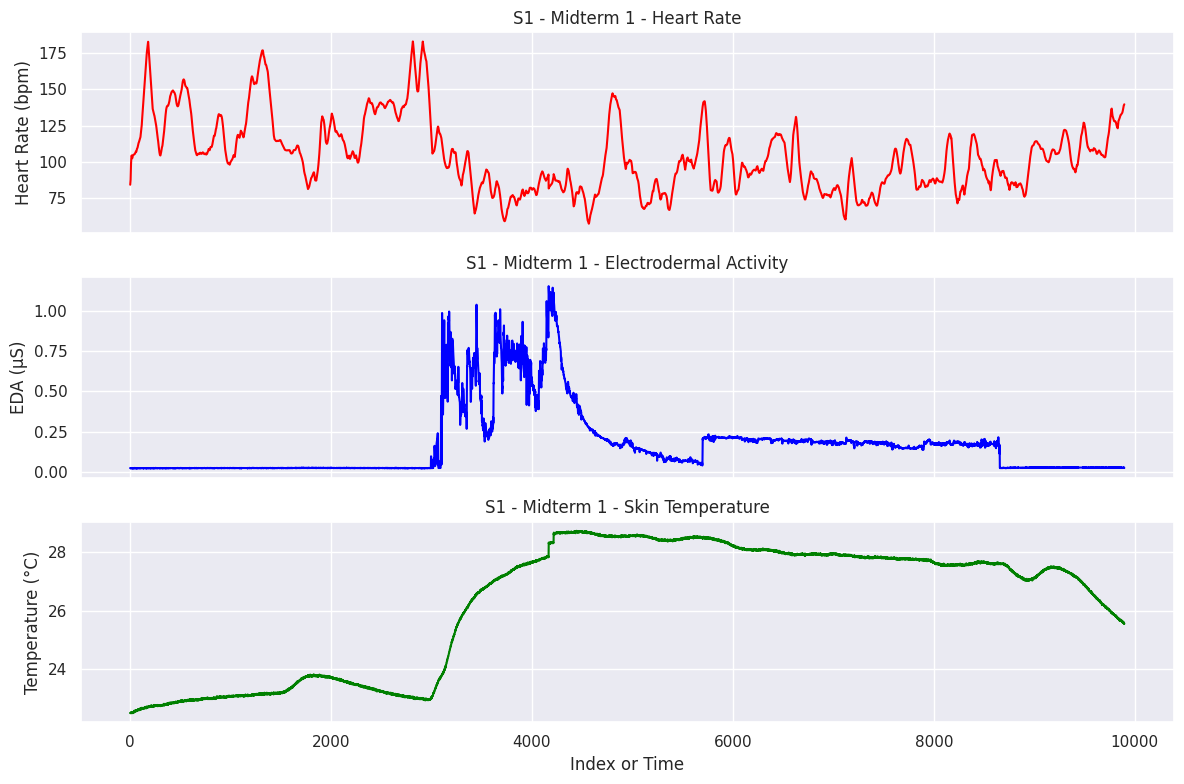

In [32]:
plot_physiological_signals(processed_df, subject_id='S1', session='Midterm 1')
